### **Step 1: Load the Data and Initial Filtering**

In this step, we begin by loading the Zillow housing data. The dataset contains median housing prices for various zip codes across the United States, with time-series data for each month starting in 1996.

We will also filter the data for a subset of zip codes of interest. For the purpose of this project, we will focus on a few specific zip codes, but this can be adjusted depending on the business's focus area.

Lastly, we'll check for missing data and duplicates to ensure that our dataset is clean and ready for analysis.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Load the Zillow data
df = pd.read_csv('Data/zillow_data.csv')

# Display first few rows to understand the structure
df.head()

# Check for missing data and duplicates
missing_data = df.isnull().sum()
print("Missing data summary:")
print(missing_data)

# Drop duplicates
df = df.drop_duplicates()


Missing data summary:
RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64


### **Step 2: Data Preprocessing**
We'll convert time columns to datetime objects, ensure correct formatting, and handle NaNs.


In [3]:
# Convert date columns to datetime
def get_datetimes(df):
    # Filter columns that represent dates
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    return pd.to_datetime(date_cols, format='%Y-%m')

# Convert and check for missing values
dates = get_datetimes(df)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# Ensure no NaNs remain
print("Remaining NaN values:", df.isnull().sum().sum())


Remaining NaN values: 0


### **Step 3: Reshape from Wide to Long Format**
We will reshape the dataset to long format to make it suitable for time series analysis.


In [4]:
# Reshape data from wide to long format
def melt_data(df):
    # Identify date columns
    date_cols = [col for col in df.columns if col.startswith('19') or col.startswith('20')]
    
    # Melt data
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], 
                     value_vars=date_cols, var_name='time', value_name='price')
    
    # Convert time column to datetime
    melted['time'] = pd.to_datetime(melted['time'], format='%Y-%m', errors='coerce')
    
    return melted

# Apply reshaping
df_long = melt_data(df)
df_long.head()


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,price
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


### **Step 4: Identify Top Growth Zip Codes**
We will identify the top 20 zip codes with the highest average price growth to guide stakeholders in investment decisions.


In [36]:
# Calculate the percentage price change over the last 5 years
df['price_change'] = df.iloc[:, -60:].pct_change(axis=1).mean(axis=1)

# Sort by price growth and select the top 5 zip codes based on price change
top_growth_zip_codes = df.sort_values(by='price_change', ascending=False).head(20)['RegionName'].tolist()

# Display the top growth zip codes
print("Top 5 growth zip codes for investment:", top_growth_zip_codes)


Top 5 growth zip codes for investment: [2116, 96722, 31527, 94803, 96752, 96716, 94525, 49636, 60611, 93301, 54230, 70431, 62216, 49253, 90013, 41007, 94621, 60541, 90014, 64156]


### **Step 5: Exploratory Data Analysis (EDA)**
Visualizing the price trends over time for the selected top 5 zip codes to identify patterns.


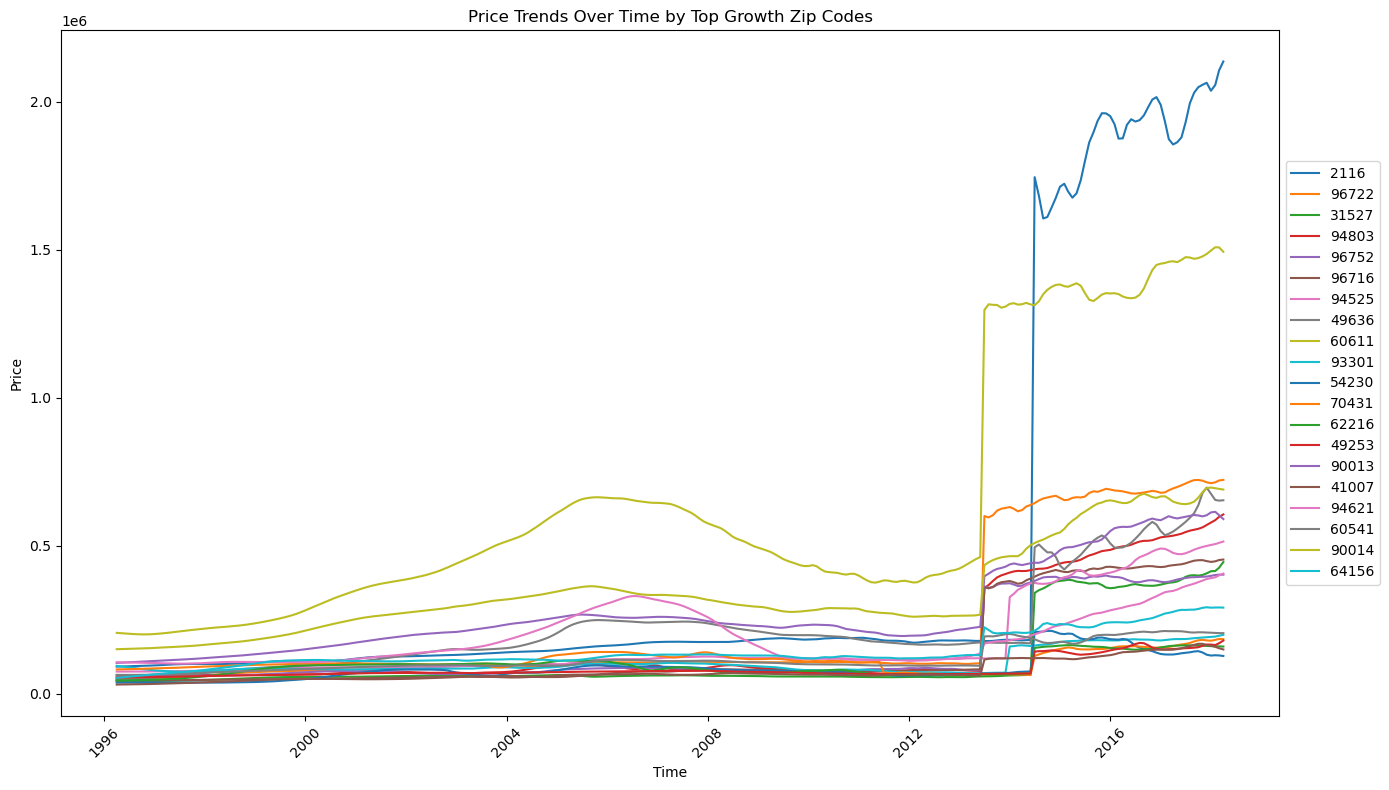

In [37]:
# Visualization of trends for top growth zip codes
plt.figure(figsize=(14, 8))

for zip_code in top_growth_zip_codes:
    zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price']
    
    # Plot each zip code's trend
    plt.plot(zip_data.index, zip_data.values, label=str(zip_code))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Trends Over Time by Top Growth Zip Codes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Step 6: Stationarity Check & Detrending**
We will check the stationarity of the time series, apply detrending, and handle non-stationary data.


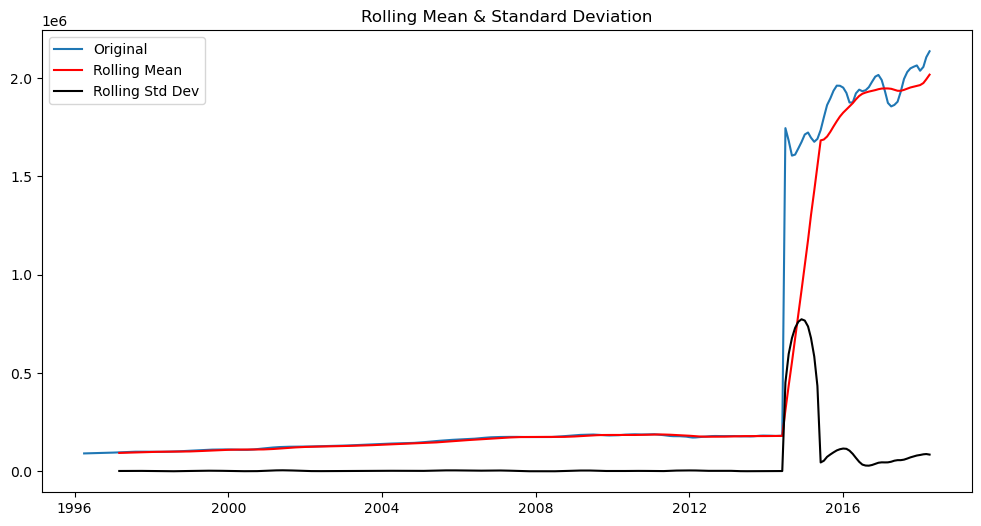

ADF Statistic: 0.115767640244289
p-value: 0.9671212812335473
Critical Values:
	1%: -3.455365238788105
	5%: -2.8725510317187024
	10%: -2.5726375763314966


In [38]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity using ADF test
def check_stationarity(data, window=12):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(data, label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Augmented Dickey-Fuller test
    adf_result = adfuller(data.dropna())
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')

# Example stationarity check for the first top growth zip code
zip_code_data = df_long[df_long['RegionName'] == top_growth_zip_codes[0]].set_index('time')['price']
check_stationarity(zip_code_data)


#### Apply First-order Differencing to Achieve Stationarity

We will apply first-order differencing to remove the trend. Differencing is the most common method to make the data stationary.

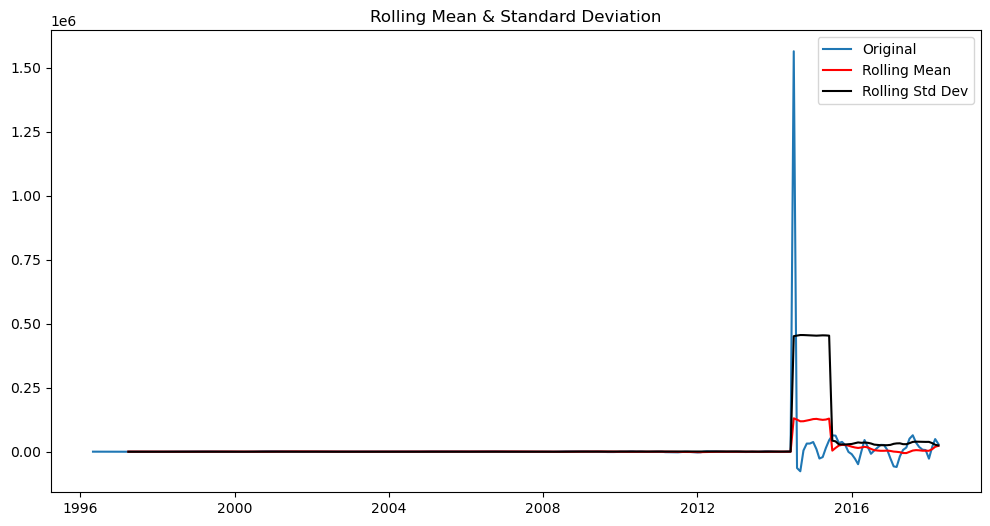

ADF Statistic: -16.655783725275388
p-value: 1.589696291185351e-29
Critical Values:
	1%: -3.4554613060274972
	5%: -2.8725931472675046
	10%: -2.5726600403359887


In [8]:
# Apply first-order differencing
differenced_data = zip_code_data.diff().dropna()

# Recheck stationarity after differencing
check_stationarity(differenced_data)


### **Step 7: Seasonality & ACF/PACF Analysis**
Analyze seasonality and correlation to identify the parameters for ARIMA modeling.


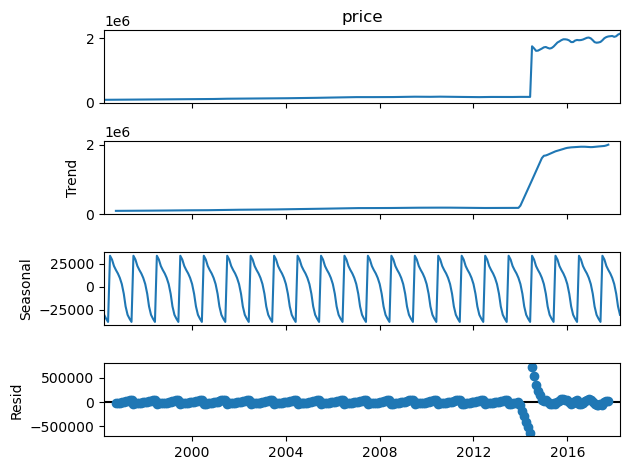

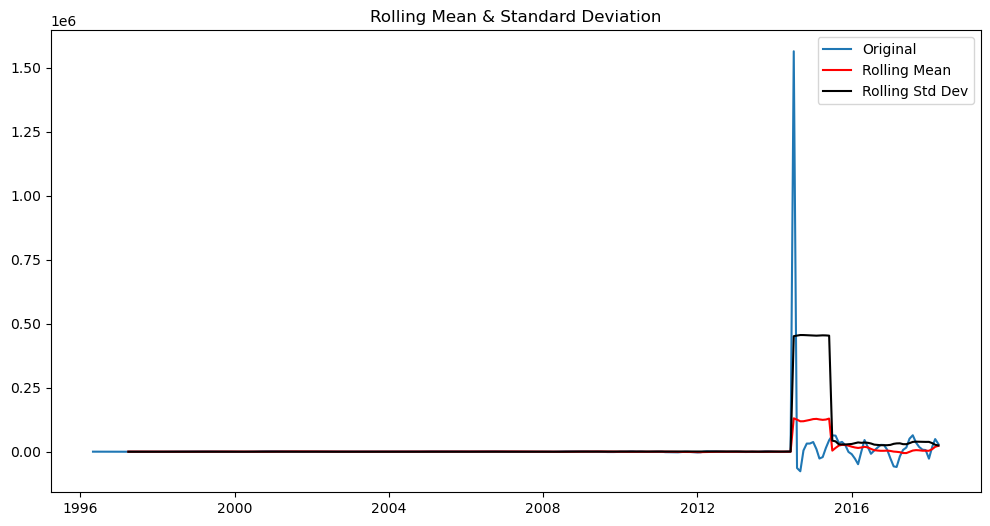

ADF Statistic: -16.655783725275388
p-value: 1.589696291185351e-29
Critical Values:
	1%: -3.4554613060274972
	5%: -2.8725931472675046
	10%: -2.5726600403359887


<Figure size 1200x600 with 0 Axes>

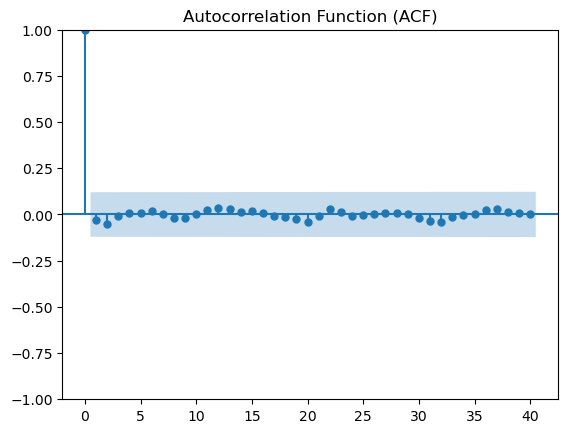

<Figure size 1200x600 with 0 Axes>

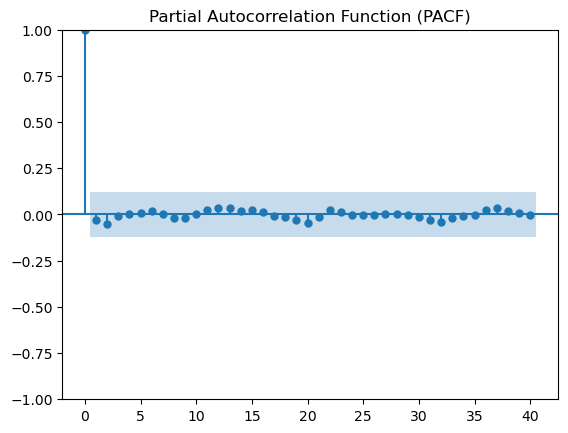

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Seasonal decomposition
def decompose_seasonality(data, frequency=12):
    decomposition = seasonal_decompose(data, model='additive', period=frequency)
    decomposition.plot()
    plt.show()

# Apply decomposition
decompose_seasonality(zip_code_data)

# Differencing to handle non-stationarity if needed
differenced_data = zip_code_data.diff().dropna()
check_stationarity(differenced_data)  # Check stationarity after differencing

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(differenced_data, lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(differenced_data, lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


#### Summary of Key Insights for Investment Decision

- **Seasonality & Trend Stability**: The data exhibits clear seasonal patterns, indicating predictable annual cycles that are useful for timing investments.
- **Sharp Trend Change**: A significant trend increase around 2012–2014 suggests a notable market event; stakeholders should investigate the cause for better context.
- **Stationarity Achieved**: After first-order differencing, the data is confirmed as stationary, ensuring reliable forecasts with ARIMA.
- **Simplified Modeling**: ACF and PACF plots show minimal autocorrelation beyond the first lag, indicating that a less complex model can provide accurate predictions.
- **Dependable Forecasts**: With stationary data, future projections are more stable, making the chosen top zip codes reliable for long-term investment.
- **Data-Driven Decisions**: Insights from seasonality, trends, and forecast accuracy provide a strong foundation for identifying the top 5 zip codes for strategic investment.


### **Step 8: ARIMA Modeling and Forecasting**
In this step, we will use the insights from the ACF/PACF analysis to build an ARIMA model. The goal is to forecast future trends for the top growth zip codes identified earlier and provide investment recommendations based on the projections.


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


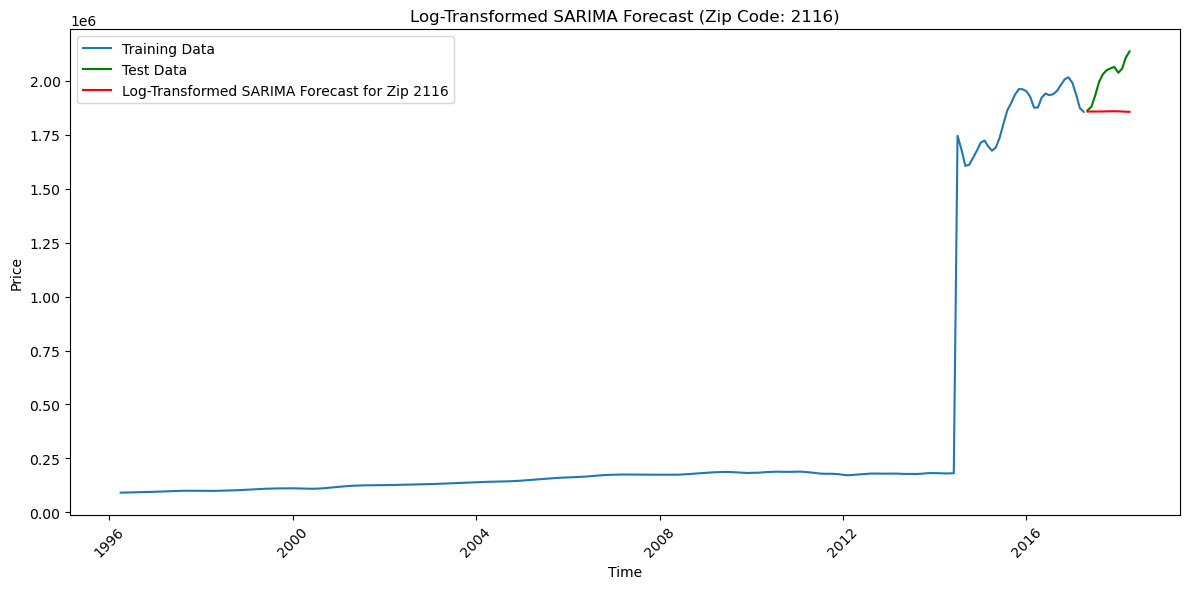

Zip Code 2116 - MAE: 159582.78, RMSE: 179200.04


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


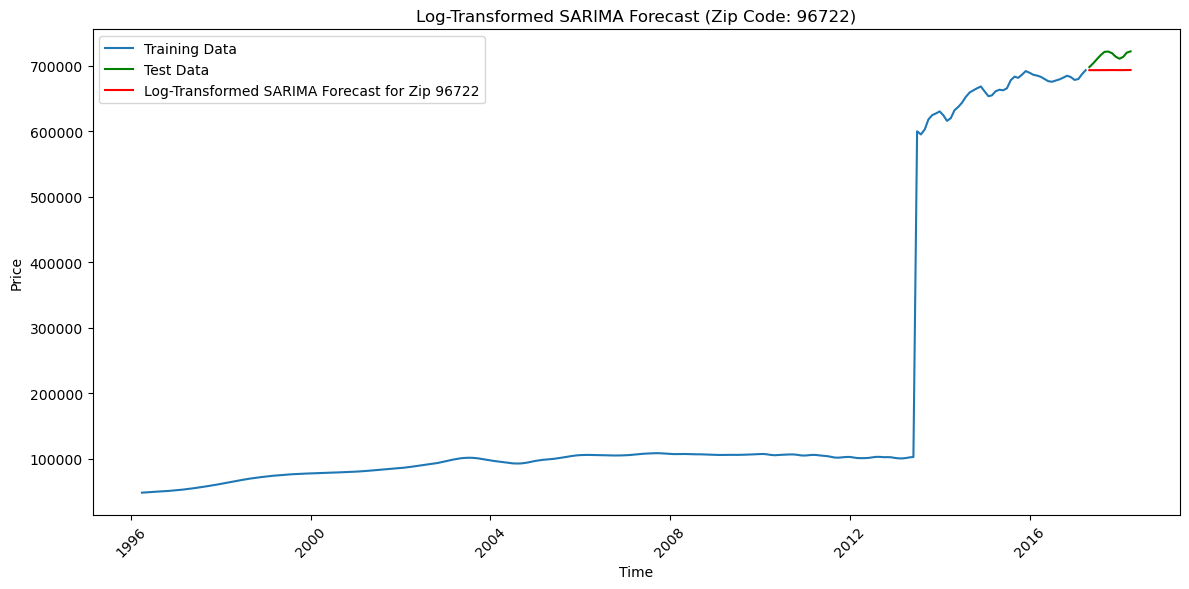

Zip Code 96722 - MAE: 20817.62, RMSE: 22038.41


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


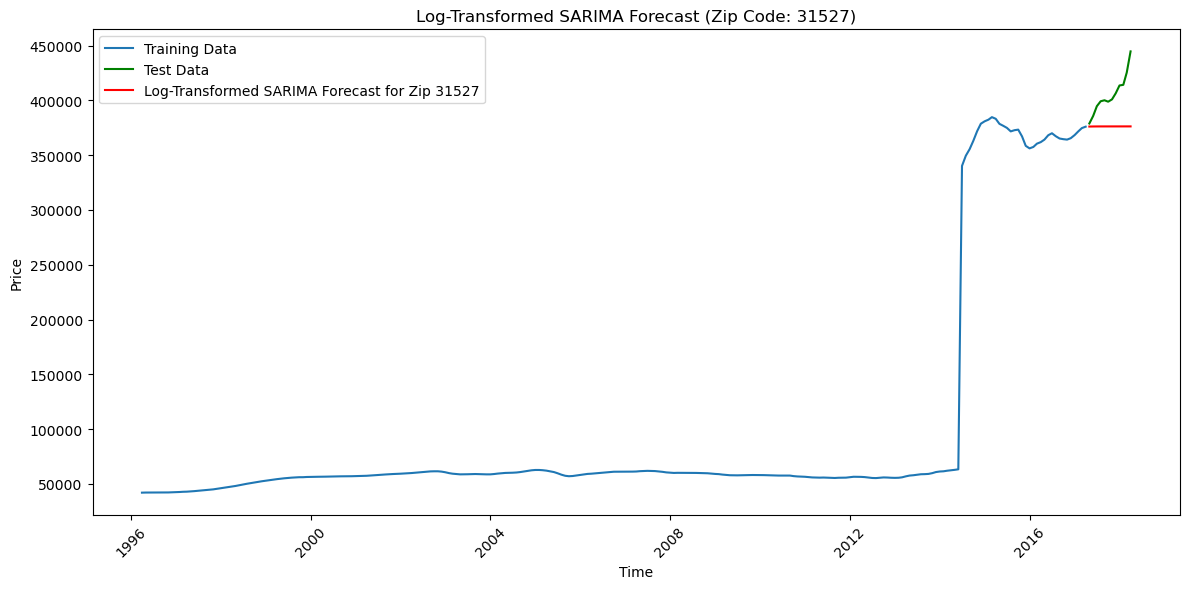

Zip Code 31527 - MAE: 29000.03, RMSE: 33543.12


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


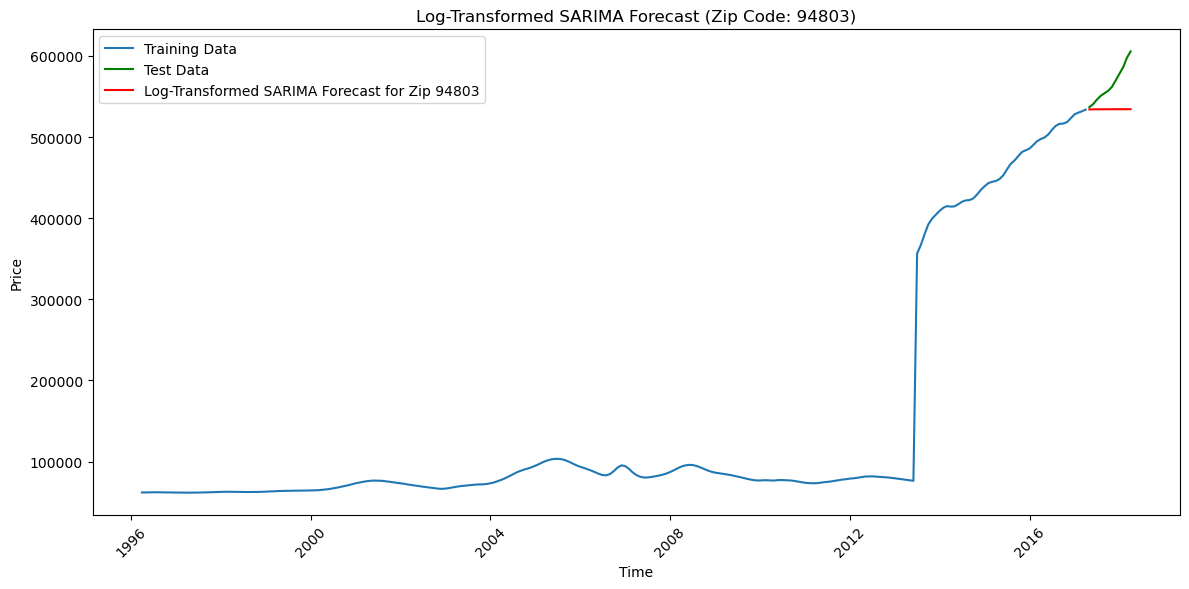

Zip Code 94803 - MAE: 31110.53, RMSE: 37706.74


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


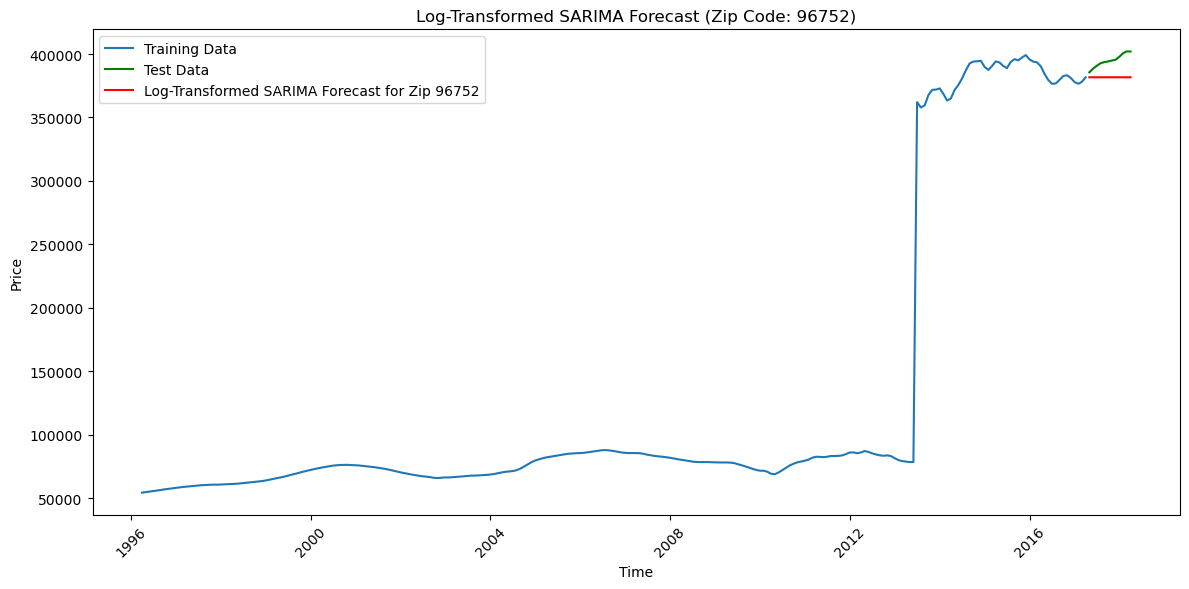

Zip Code 96752 - MAE: 13229.43, RMSE: 14132.53


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


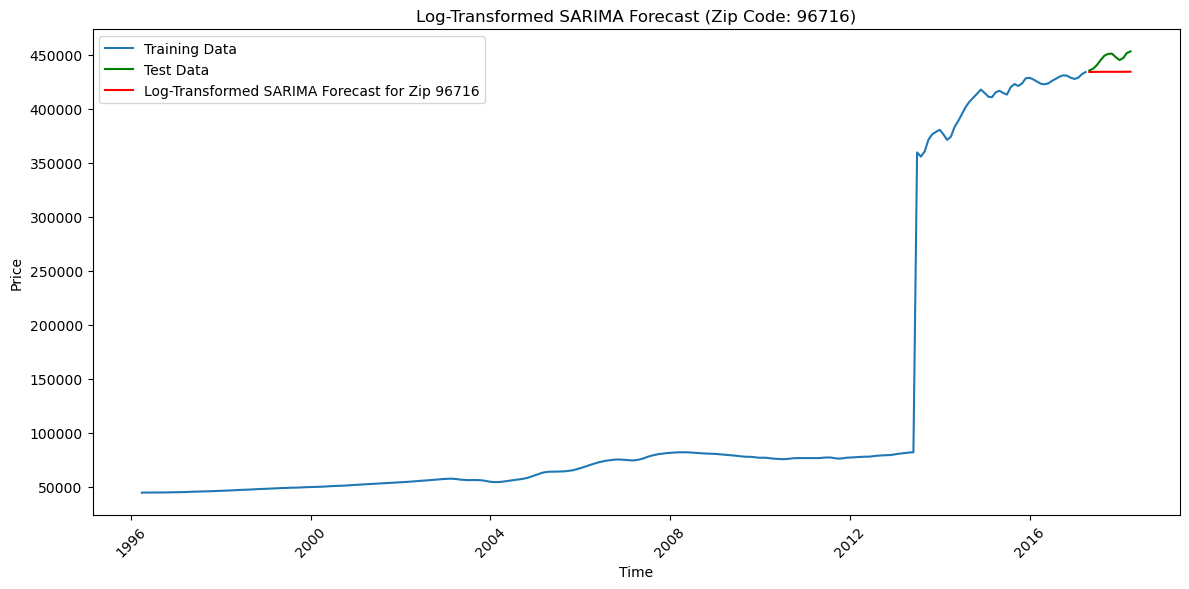

Zip Code 96716 - MAE: 11934.59, RMSE: 13127.77


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


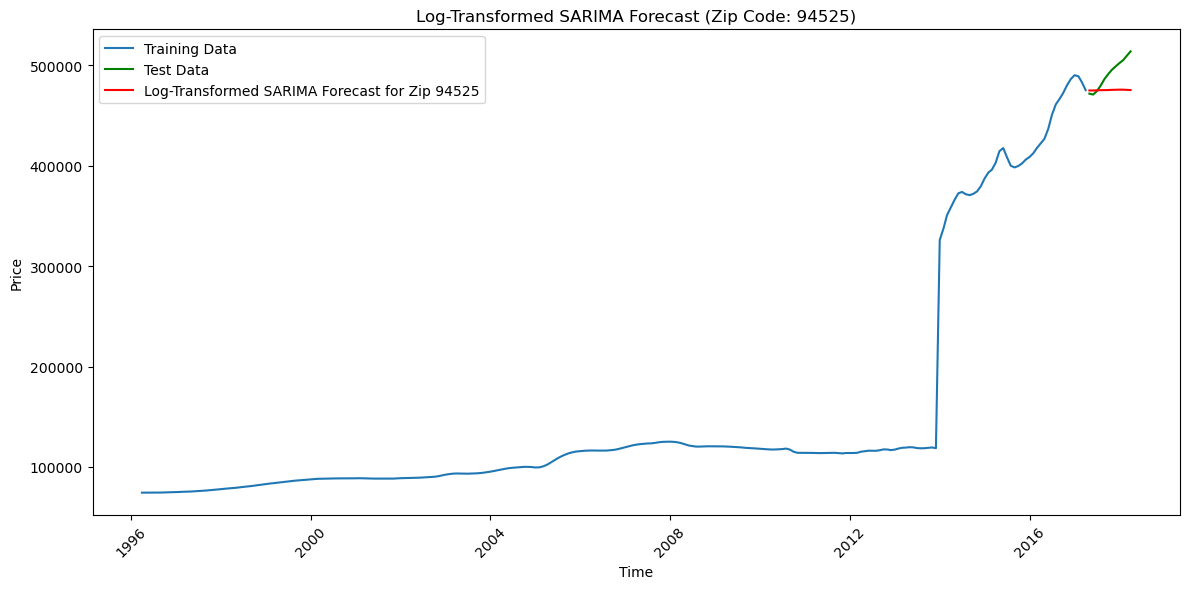

Zip Code 94525 - MAE: 17620.04, RMSE: 21565.41


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


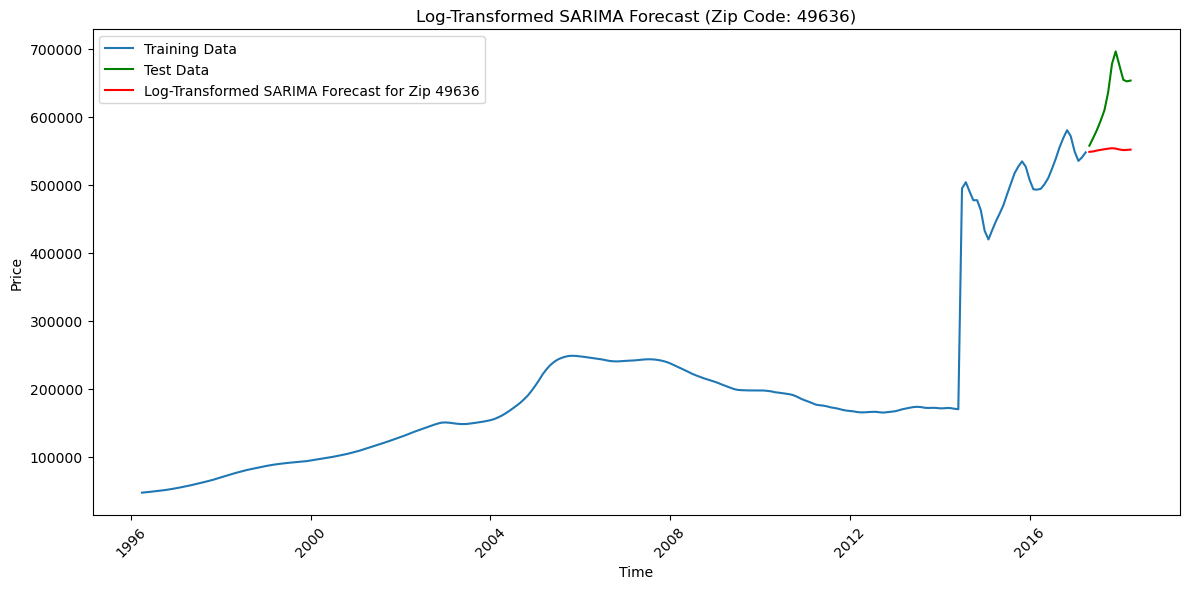

Zip Code 49636 - MAE: 78218.16, RMSE: 89280.89


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


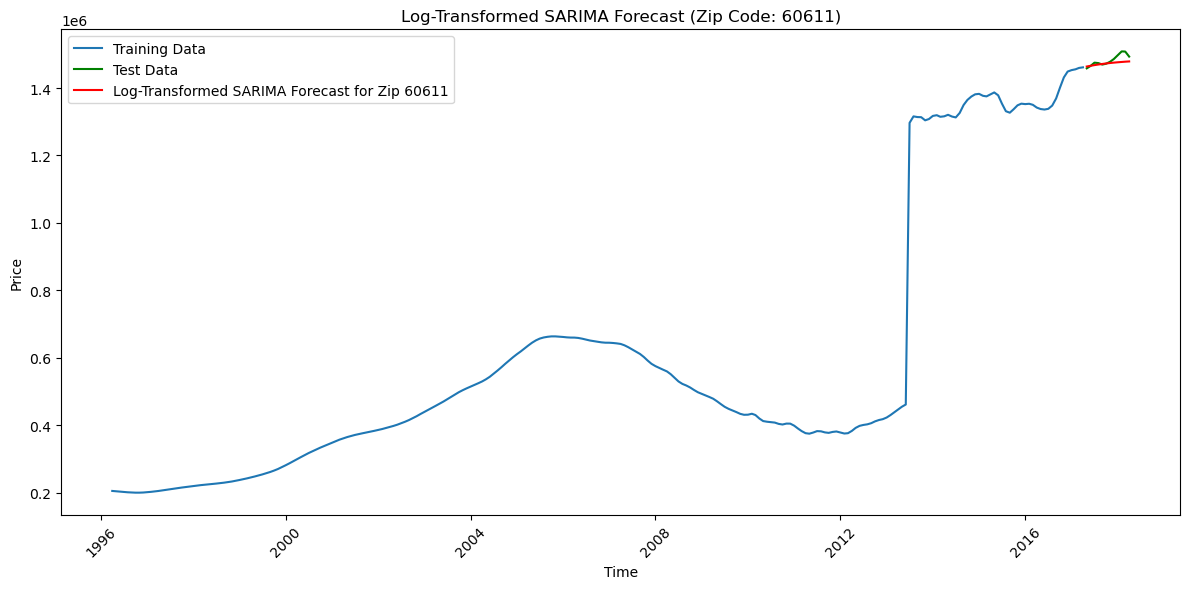

Zip Code 60611 - MAE: 10887.42, RMSE: 15165.91


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


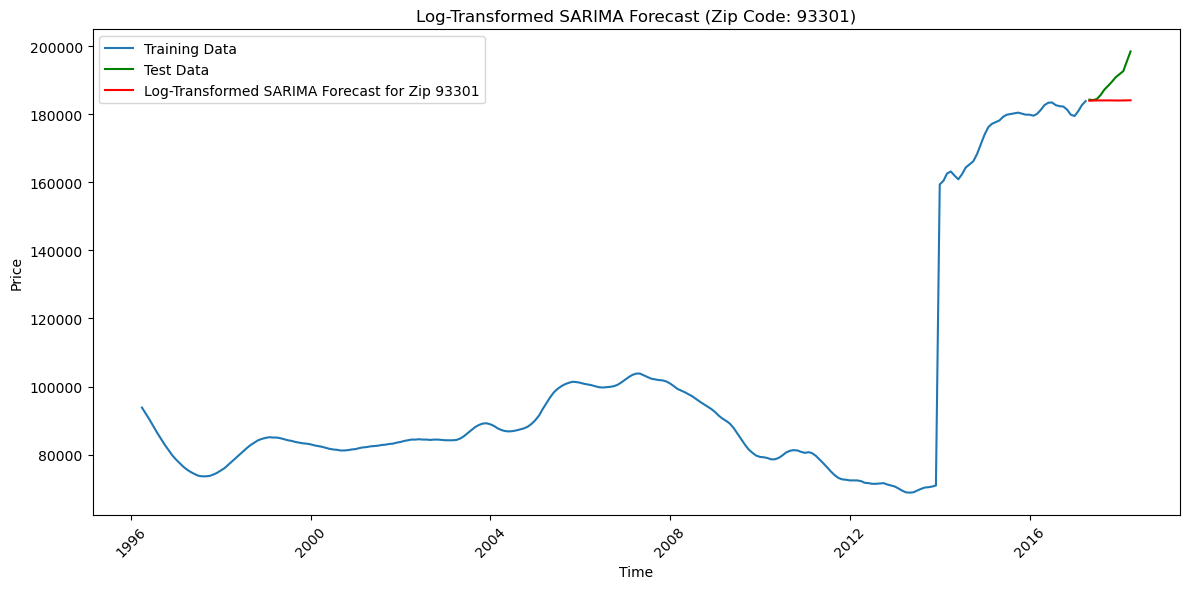

Zip Code 93301 - MAE: 5369.89, RMSE: 6948.09


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


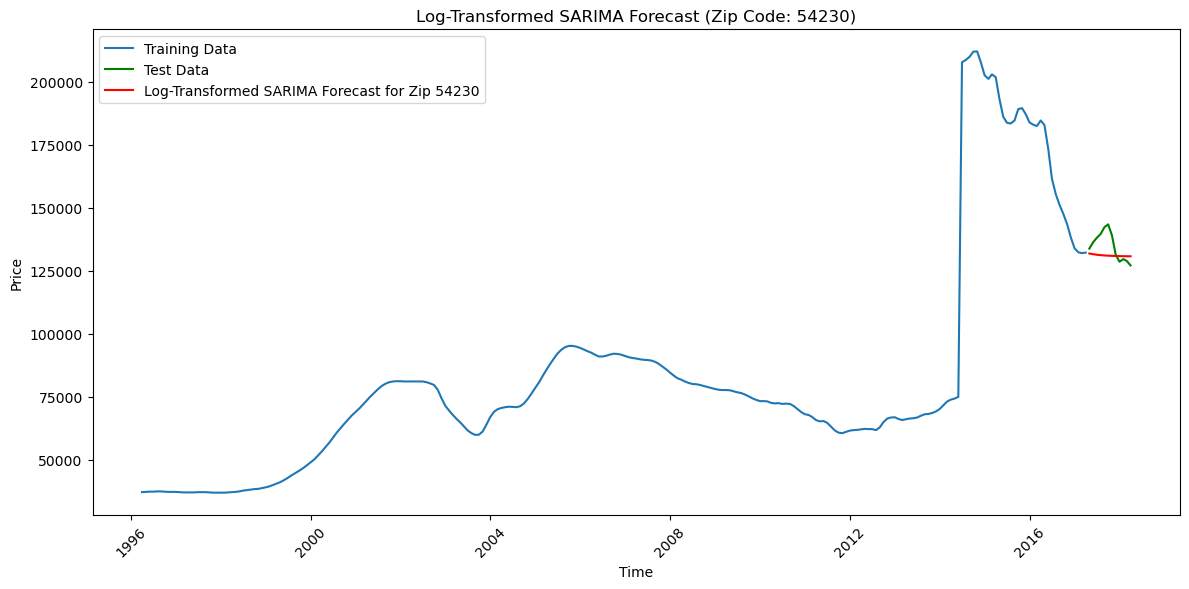

Zip Code 54230 - MAE: 5249.95, RMSE: 6527.17


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


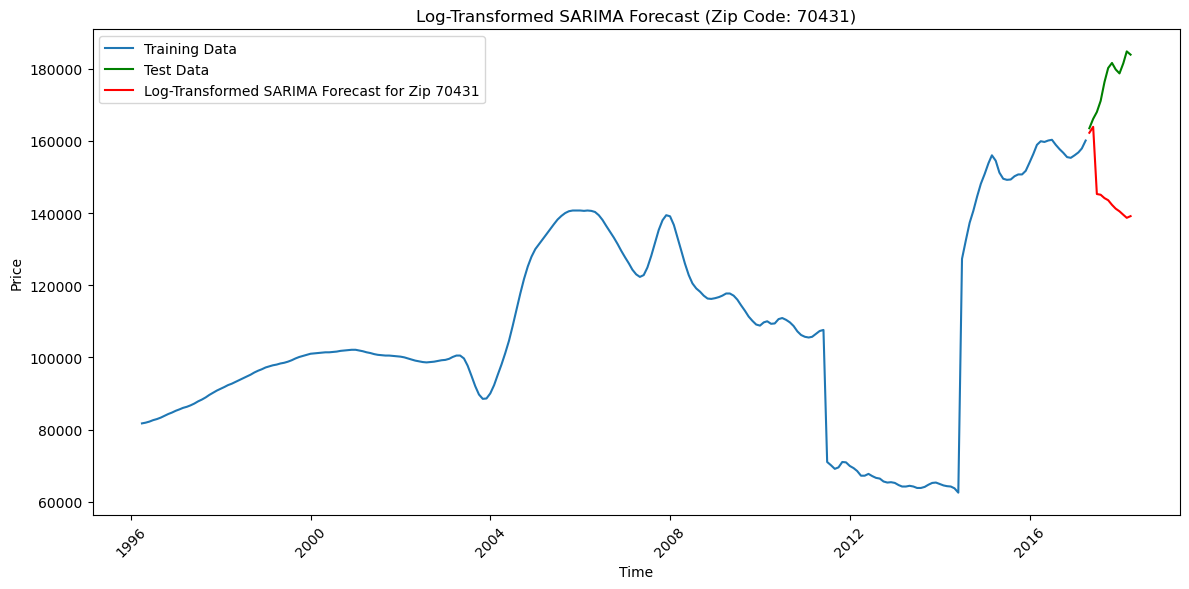

Zip Code 70431 - MAE: 30837.28, RMSE: 34118.55


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


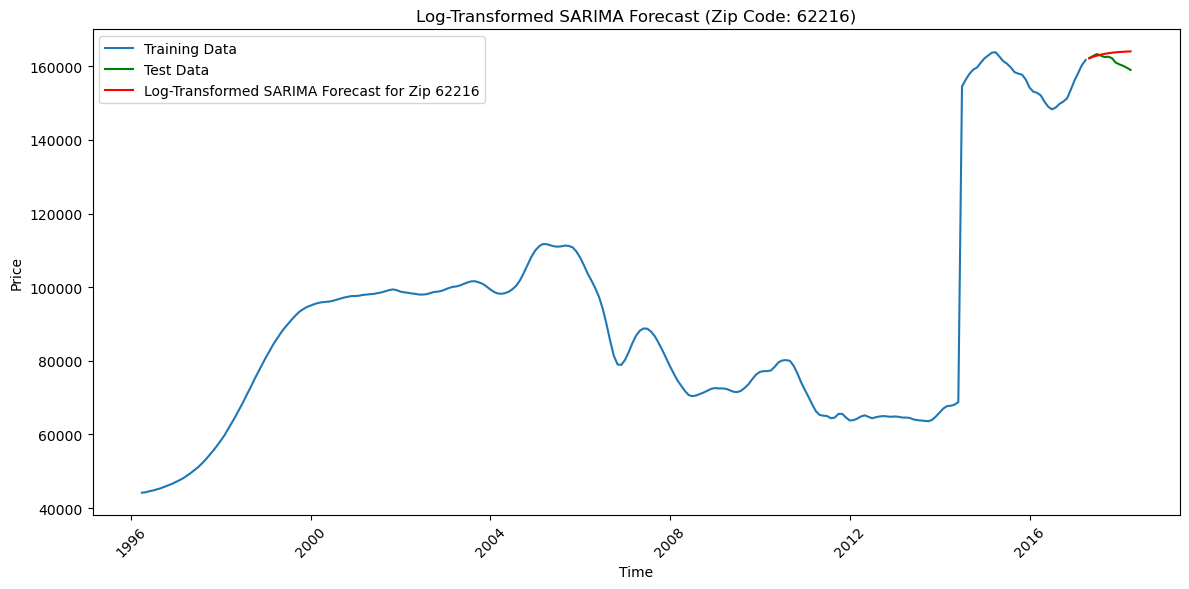

Zip Code 62216 - MAE: 1967.75, RMSE: 2623.26


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


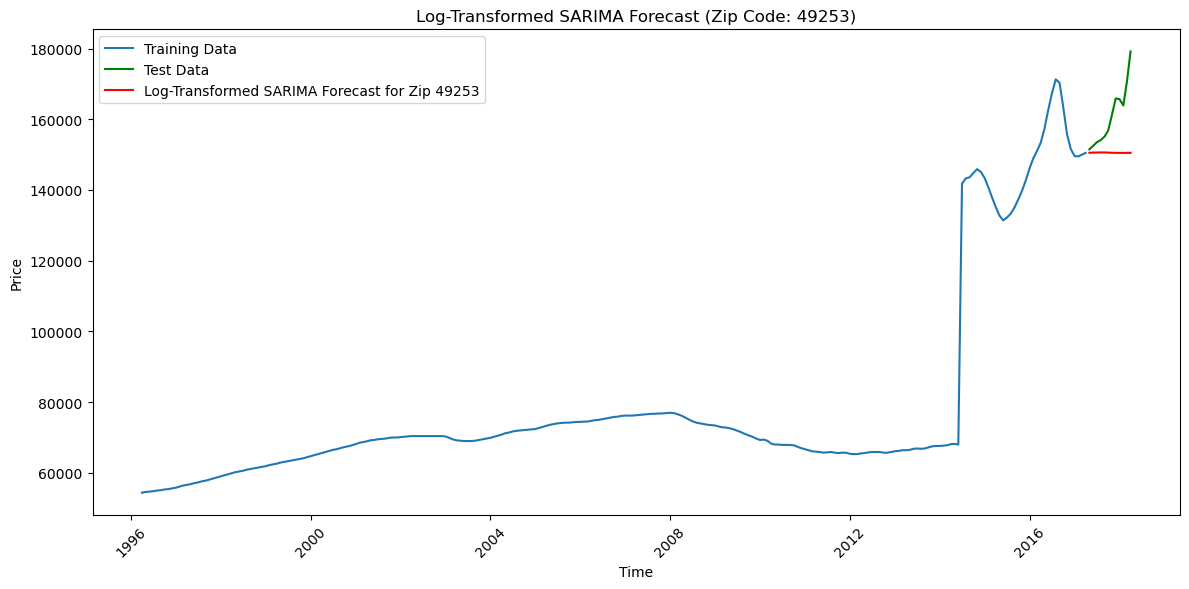

Zip Code 49253 - MAE: 10269.04, RMSE: 13111.28


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


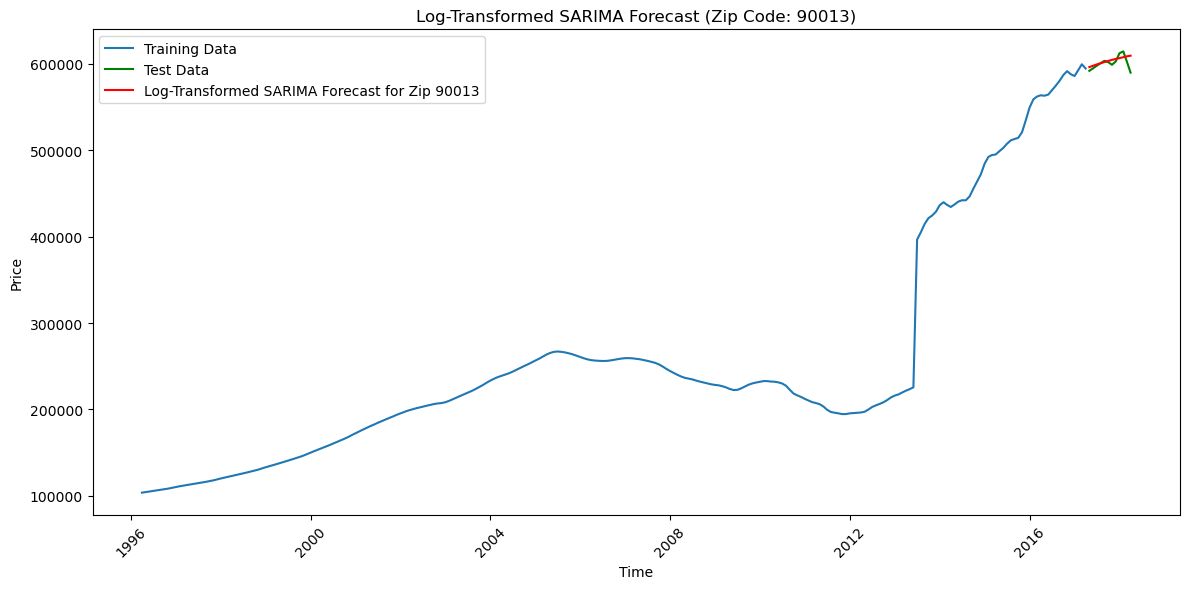

Zip Code 90013 - MAE: 4816.51, RMSE: 6887.88


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


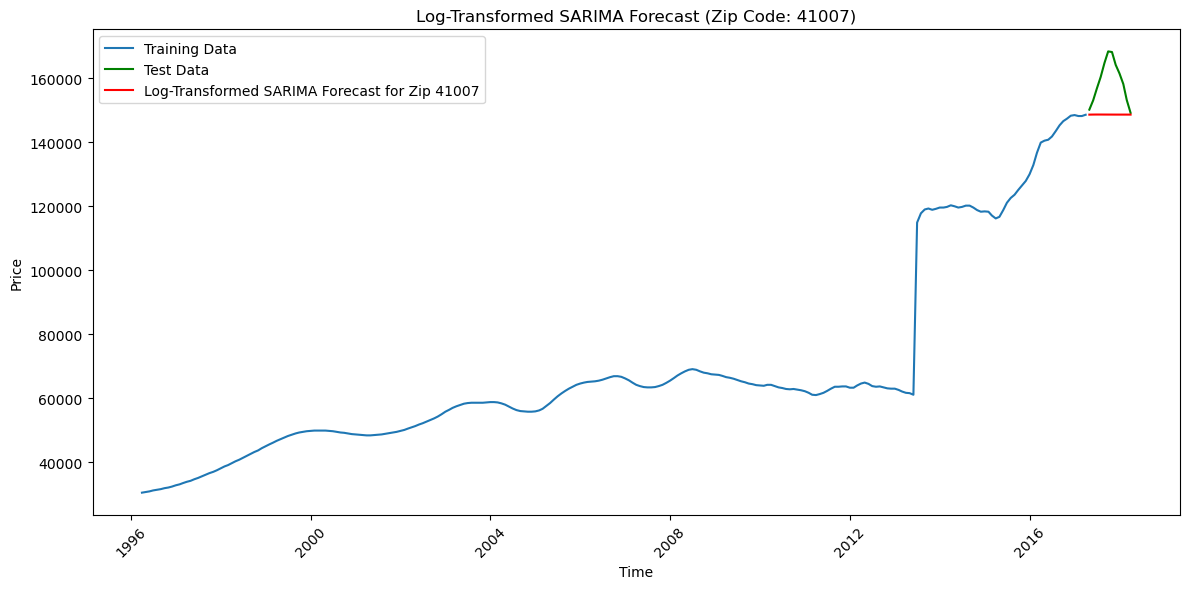

Zip Code 41007 - MAE: 10362.66, RMSE: 12170.19


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


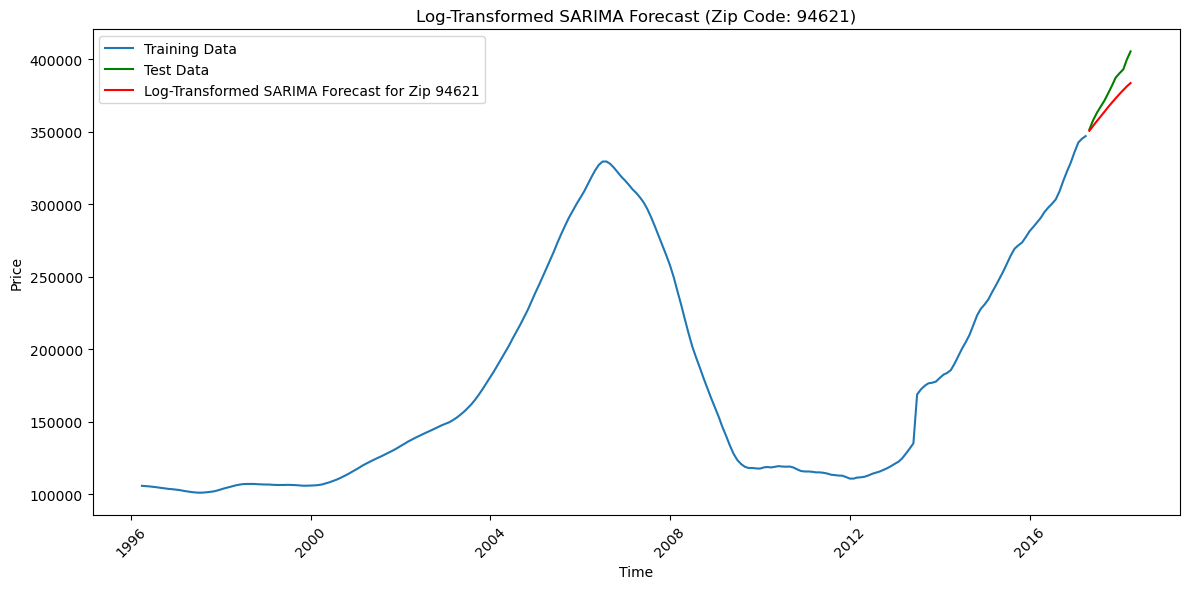

Zip Code 94621 - MAE: 10758.27, RMSE: 12263.26


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


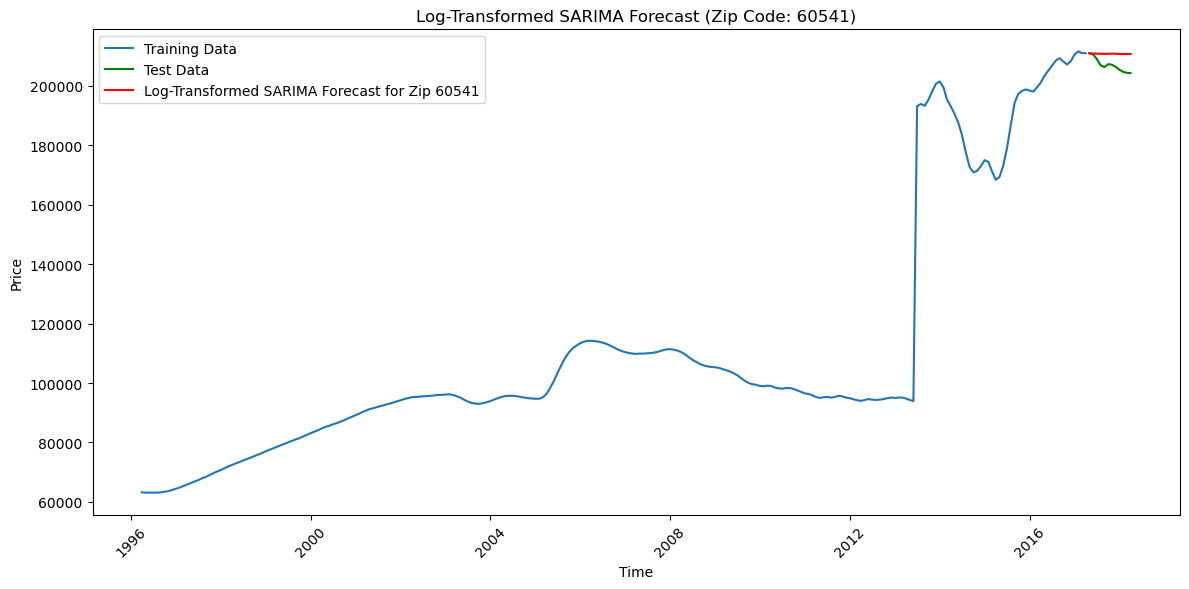

Zip Code 60541 - MAE: 3859.17, RMSE: 4379.53


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


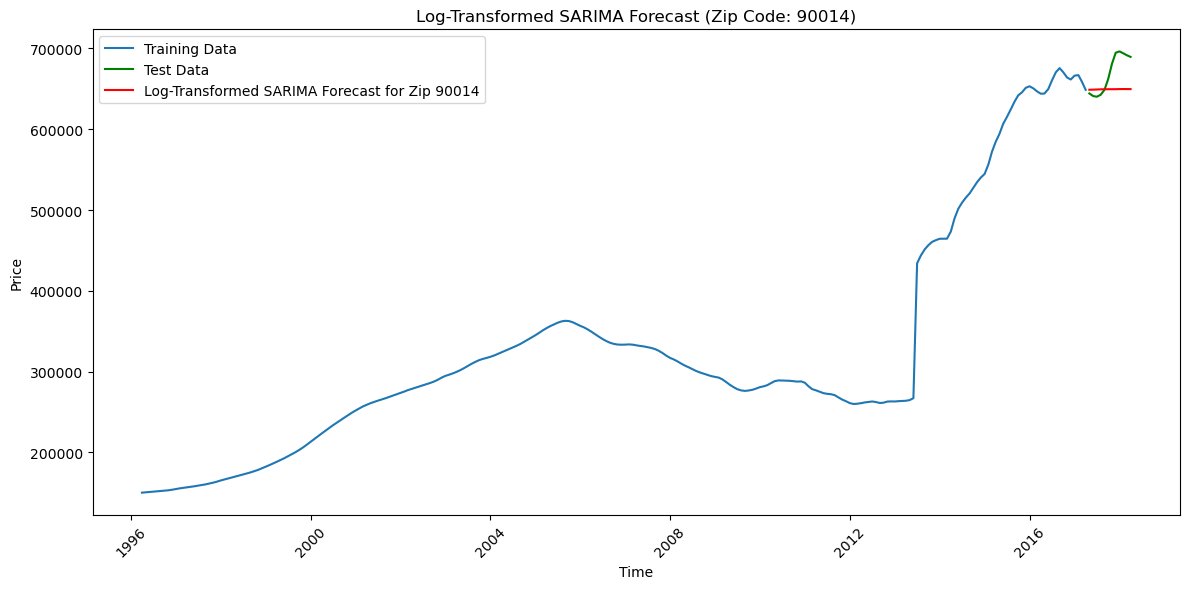

Zip Code 90014 - MAE: 24233.14, RMSE: 30106.66


c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\neali\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


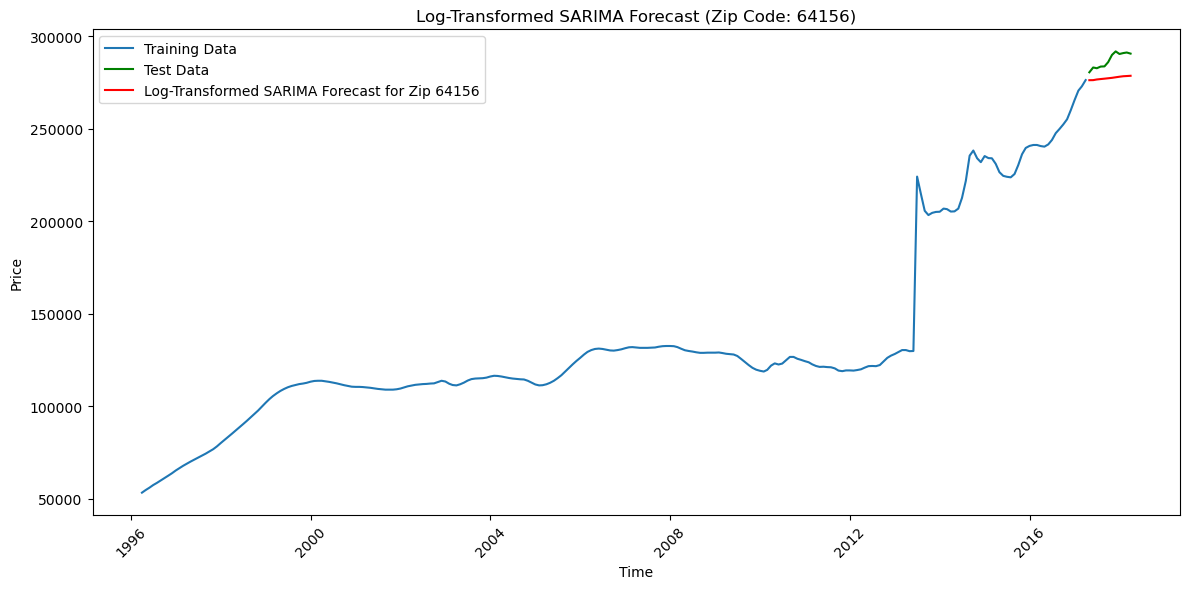

Zip Code 64156 - MAE: 9604.19, RMSE: 10129.86

Top 5 Zip Codes by Lowest MAE:
       ZipCode          MAE
62216    62216   1967.74569
60541    60541  3859.171238
90013    90013  4816.513662
54230    54230  5249.954788
93301    93301  5369.894931

Top 5 Zip Codes by Lowest RMSE:
       ZipCode         RMSE
62216    62216  2623.264456
60541    60541  4379.529304
54230    54230  6527.166517
90013    90013  6887.876556
93301    93301  6948.088638


In [40]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming top_growth_zip_codes already contains the top 20 zip codes, e.g., ['27980', '30032', ...]
# We will directly use the top_growth_zip_codes list for analysis

# Store results for each zip code
zip_code_results = {}

# Iterate over each top zip code
for zip_code in top_growth_zip_codes:
    # Load data for the specific zip code
    zip_data = df_long[df_long['RegionName'] == zip_code].set_index('time')['price']
    
    # Split data into training and test sets
    train_data = zip_data[:-12]  # Train set: All but the last 12 months
    test_data = zip_data[-12:]   # Test set: The last 12 months

    # Log transformation on training and test data
    log_train_data = np.log(train_data)
    log_test_data = np.log(test_data)
    
    # Fit the SARIMA model using log-transformed data
    seasonal_order = (1, 0, 1, 12)  # Seasonal configuration for SARIMA
    log_sarima_model = SARIMAX(log_train_data, order=(1, 1, 1), seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    log_sarima_model_fit = log_sarima_model.fit()
    
    # Forecast for the next 12 months using the log-transformed SARIMA model
    log_forecast = log_sarima_model_fit.forecast(steps=12)
    
    # Revert log transformation by exponentiating the forecasted values
    reverted_forecast = np.exp(log_forecast)
    
    # Calculate errors on the reverted predictions
    mae = mean_absolute_error(test_data, reverted_forecast)
    rmse = np.sqrt(mean_squared_error(test_data, reverted_forecast))
    
    # Store results in the dictionary
    zip_code_results[zip_code] = {
        'MAE': mae,
        'RMSE': rmse,
        'Actual': test_data,
        'Forecast': reverted_forecast
    }
    
    # Plot the actual vs. forecasted data for the current zip code
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Training Data')
    plt.plot(test_data.index, test_data, label='Test Data', color='green')
    plt.plot(test_data.index, reverted_forecast, label=f'Log-Transformed SARIMA Forecast for Zip {zip_code}', color='red')
    plt.legend(loc='best')
    plt.title(f'Log-Transformed SARIMA Forecast (Zip Code: {zip_code})')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print the error metrics for the current zip code
    print(f'Zip Code {zip_code} - MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# Convert the results dictionary to a DataFrame for easy analysis
summary_df = pd.DataFrame(zip_code_results).T[['MAE', 'RMSE']]
summary_df['ZipCode'] = summary_df.index

# Sort and display the summary of the top 5 zip codes with the lowest MAE and RMSE
top_5_mae = summary_df.sort_values(by='MAE').head(5)
print("\nTop 5 Zip Codes by Lowest MAE:")
print(top_5_mae[['ZipCode', 'MAE']])

top_5_rmse = summary_df.sort_values(by='RMSE').head(5)
print("\nTop 5 Zip Codes by Lowest RMSE:")
print(top_5_rmse[['ZipCode', 'RMSE']])


**Visualization for Further Insight:**

* To better understand why the model performed well or poorly in different zip codes, consider visualizing error distributions:

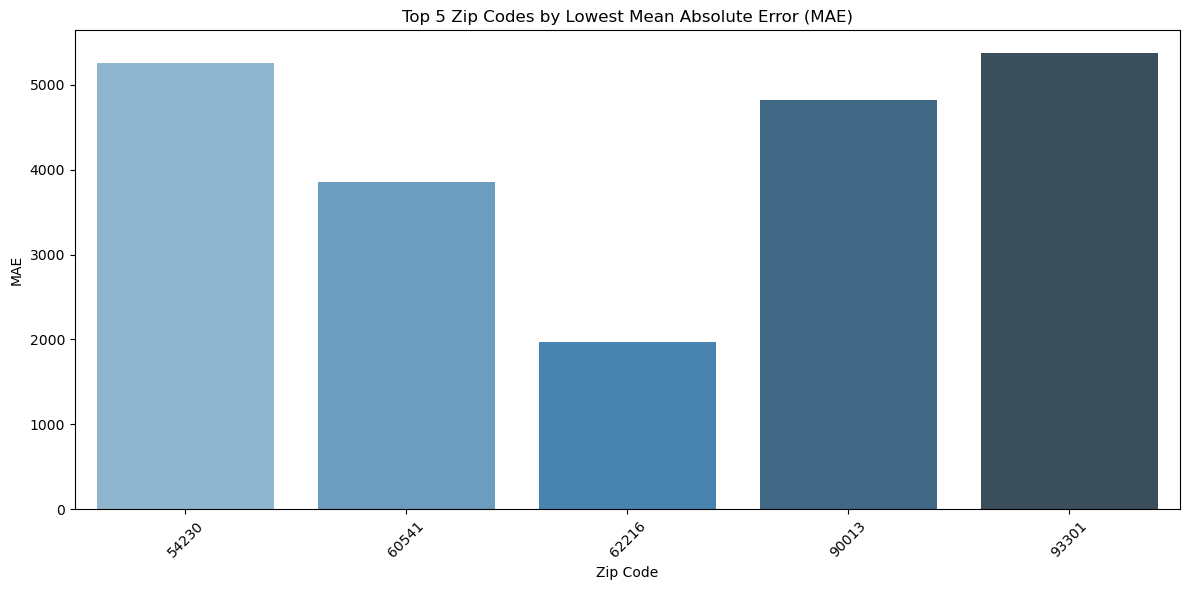

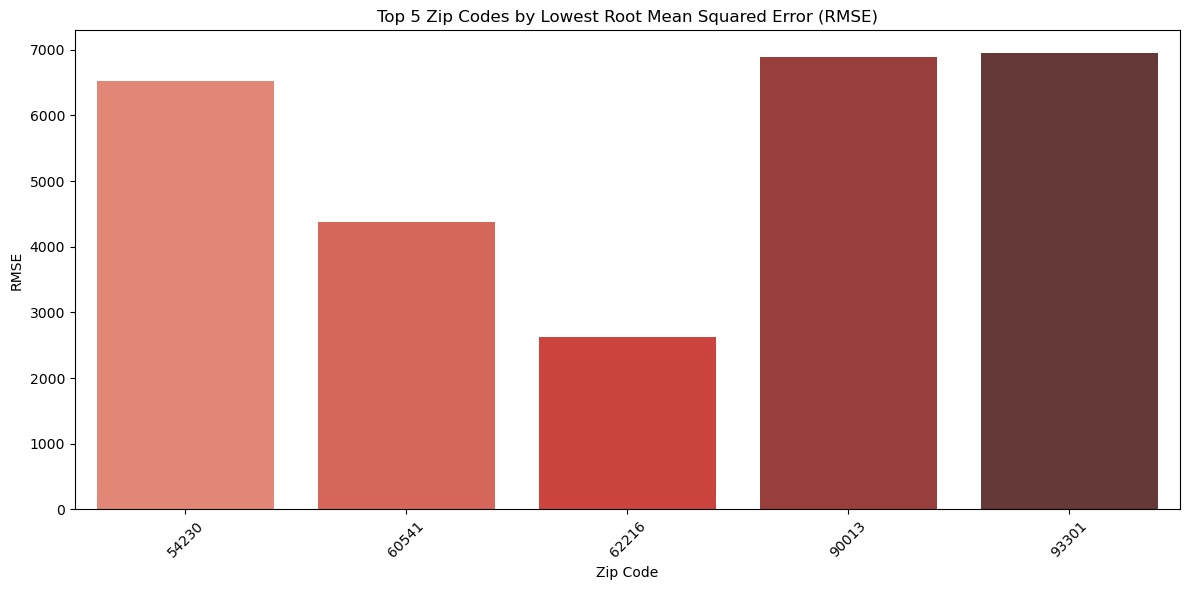

In [42]:


# Create a DataFrame for visualization
summary_df = pd.DataFrame(zip_code_results).T[['MAE', 'RMSE']]
summary_df['ZipCode'] = summary_df.index

# Identify the top 5 zip codes by lowest MAE and RMSE
top_5_mae_zipcodes = summary_df.sort_values(by='MAE').head(5)['ZipCode'].tolist()
top_5_rmse_zipcodes = summary_df.sort_values(by='RMSE').head(5)['ZipCode'].tolist()

# Filter the summary_df to only include the top 5 zip codes by MAE and RMSE
filtered_summary_mae = summary_df[summary_df['ZipCode'].isin(top_5_mae_zipcodes)]
filtered_summary_rmse = summary_df[summary_df['ZipCode'].isin(top_5_rmse_zipcodes)]

# Plot MAE for the top 5 zip codes based on lowest MAE
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_summary_mae, x='ZipCode', y='MAE', palette='Blues_d')
plt.title('Top 5 Zip Codes by Lowest Mean Absolute Error (MAE)')
plt.xlabel('Zip Code')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot RMSE for the top 5 zip codes based on lowest RMSE
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_summary_rmse, x='ZipCode', y='RMSE', palette='Reds_d')
plt.title('Top 5 Zip Codes by Lowest Root Mean Squared Error (RMSE)')
plt.xlabel('Zip Code')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
